In [ ]:
#CRISP-DM Project Outline
#This notebook provides an outline for a data science project following the CRISP-DM methodology.
#State of art
#Aujourd’hui, les plateformes de mobilité comme Uber utilisent beaucoup les nouvelles technologies et l’analyse des informations pour mieux fonctionner et offrir une meilleure expérience aux utilisateurs. Elles arrivent ainsi à relever plusieurs défis, comme donner un prix plus juste en temps réel, prévoir plus précisément l’heure d’arrivée d’un véhicule, ou encore mieux connaître les habitudes des clients afin de leur proposer des offres adaptées. En s’appuyant sur l’étude de grandes quantités de données issues des trajets, du comportement des passagers et des conditions extérieures comme le trafic, la météo ou l’heure de la journée, ces entreprises réussissent à prendre de meilleures décisions. Cela leur permet d’être plus efficaces, de réduire les annulations de courses et de renforcer la fidélité des clients.#1. Business Understanding
#Define the Business Objectives (BOs)
#BO 1:Fournir une estimation fiable et rapide du coût d’un trajet Uber.
#BO 2:Réduire les temps d’attente des passagers d'un uberen prédisant leur ETA (Estimated Time of Arrival)
#BO 3:Identifier et anticiper les zones de forte demande (hotspots) afin de mieux répartir les chauffeurs et éviter les ruptures de disponibilité.
#Define the Data Science Objectives (DSOs)
#DSO 1:Construire un modèle de régression robuste qui prédit le fare_amount avec une erreur faible (MAE/RMSE bas).
#DSO 2:Développer un modèle prédictif capable d’estimer la durée du trajet afin de fournir au client un temps d’arrivée réaliste
#DSO 3:Appliquer des techniques de clustering non supervisé (ex. K-Means, DBSCAN) pour segmenter les trajets selon le lieu


Aperçu des données :
   Unnamed: 0                            key  fare_amount  \
0  24238194.0    2015-05-07 19:52:06.0000003          7.5   
1  27835199.0    2009-07-17 20:04:56.0000002          7.7   
2  44984355.0   2009-08-24 21:45:00.00000061         12.9   
3  25894730.0    2009-06-26 08:22:21.0000001          5.3   
4  17610152.0  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2                      NaN        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124              NaN   
4  2014-08-28 17:47:00 UTC               NaN        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217              1.0  
1         -73.994710         40.750325              1.0  
2                NaN         40.772647         

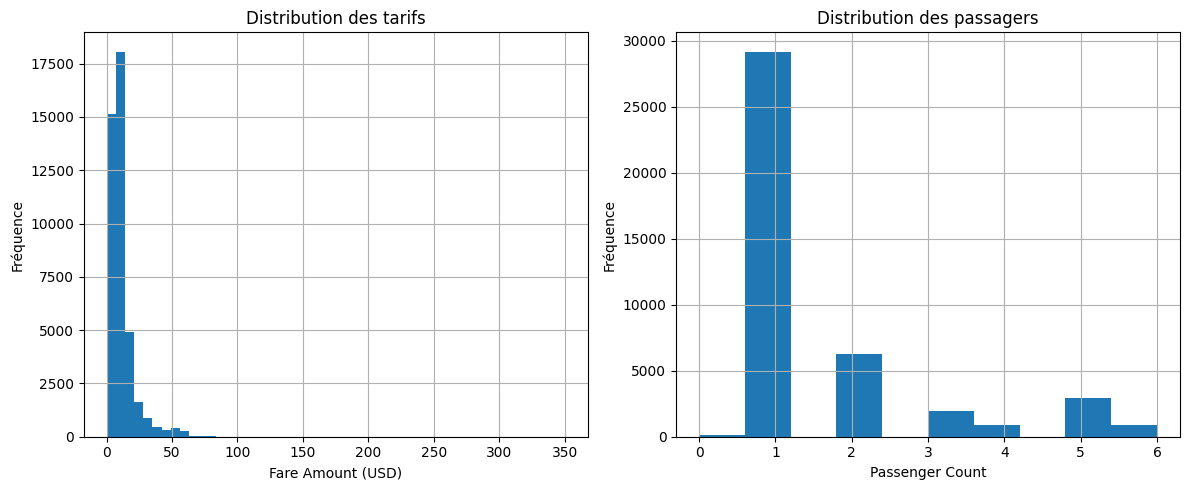


Nombre de trajets avec même départ et arrivée : 977
📌 Dimensions du dataset : (44377, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194.000000,2015-05-07 19:52:06.0000003,7.500000,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.000000
1,27835199.000000,2009-07-17 20:04:56.0000002,7.700000,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.000000
2,44984355.000000,2009-08-24 21:45:00.00000061,12.900000,nan,-74.005043,40.740770,nan,40.772647,1.000000
3,25894730.000000,2009-06-26 08:22:21.0000001,5.300000,2009-06-26 08:22:21 UTC,-73.976124,nan,-73.965316,40.803349,3.000000
4,17610152.000000,2014-08-28 17:47:00.000000188,16.000000,2014-08-28 17:47:00 UTC,nan,40.744085,-73.973082,nan,5.000000
5,44470845.000000,2011-02-12 02:27:09.0000006,4.900000,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1.000000
6,48725865.000000,2014-10-12 07:04:00.0000002,24.500000,2014-10-12 07:04:00 UTC,nan,40.693965,-73.871195,40.774297,5.000000
7,44195482.000000,2012-12-11 13:52:00.00000029,2.500000,2012-12-11 13:52:00 UTC,0.000000,0.000000,0.000000,0.000000,1.000000
8,15822268.000000,2012-02-17 09:32:00.00000043,9.700000,2012-02-17 09:32:00 UTC,-73.975187,40.745767,-74.002720,40.743537,1.000000
9,50611056.000000,2012-03-29 19:06:00.000000273,12.500000,2012-03-29 19:06:00 UTC,-74.001065,40.741787,-73.963040,nan,1.000000



📈 Statistiques descriptives :


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,42243.000000,42217.000000,42183.000000,42130.000000,42183.000000,42119.000000,42159.000000
mean,27672899.814928,11.409233,-72.568666,39.948790,-72.588555,39.957229,1.677720
std,16026783.122156,10.091979,10.776933,6.006307,10.684628,5.962407,1.296484
min,48.000000,0.000000,-748.016667,-74.015515,-737.916665,-74.008745,0.000000
25%,13724835.500000,6.000000,-73.992075,40.734808,-73.991496,40.733766,1.000000
50%,27651919.000000,8.500000,-73.981857,40.752503,-73.980170,40.752910,1.000000
75%,41510200.500000,12.600000,-73.967187,40.767077,-73.963738,40.768162,2.000000
max,55421687.000000,350.000000,40.774042,45.031653,40.828377,45.031598,6.000000


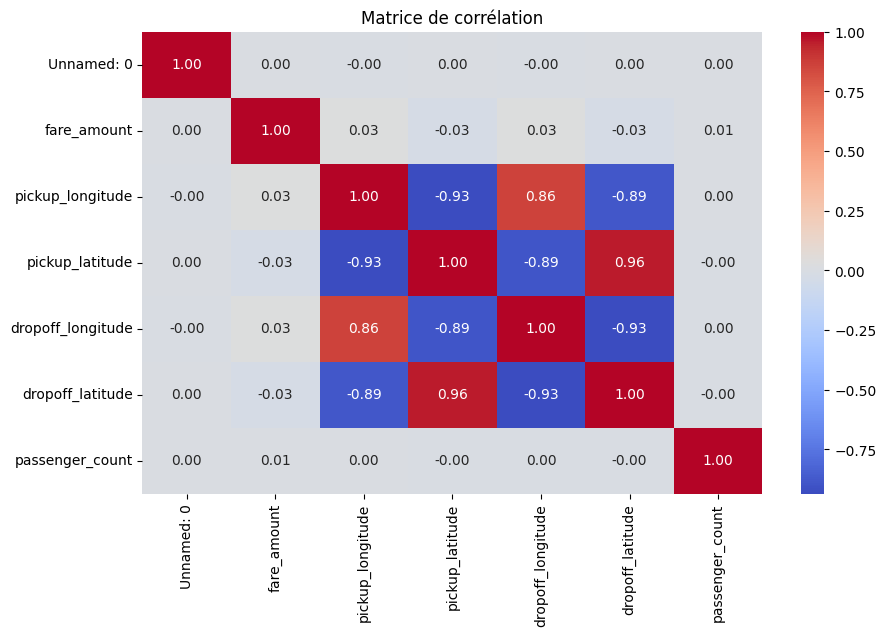

In [ ]:
#2. Data Understanding
#Collect and get an initial understanding of the data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Charger le dataset Excel (adapter le chemin)
df = pd.read_excel("datauber.xlsx")   # Mets le vrai nom de ton fichier

# 2. Aperçu des données
print("Aperçu des données :")
print(df.head())
print(df.shape)

print("\nInfos générales :")
print(df.info())

# 3. Vérifier valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

# 4. Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe(include="all"))

# 5. Vérifier les valeurs uniques pour passenger_count
print("\nValeurs uniques passenger_count :")
print(df["passenger_count"].value_counts(dropna=False))

# 6. Visualisations simples
plt.figure(figsize=(12,5))

# Distribution des tarifs
plt.subplot(1,2,1)
df["fare_amount"].hist(bins=50)
plt.xlabel("Fare Amount (USD)")
plt.ylabel("Fréquence")
plt.title("Distribution des tarifs")

# Distribution du nombre de passagers
plt.subplot(1,2,2)
df["passenger_count"].hist(bins=10)
plt.xlabel("Passenger Count")
plt.ylabel("Fréquence")
plt.title("Distribution des passagers")

plt.tight_layout()
plt.show()

# 7. Vérifier cohérence pickup vs dropoff (distance = 0)
same_location = df[
    (df["pickup_longitude"] == df["dropoff_longitude"]) &
    (df["pickup_latitude"] == df["dropoff_latitude"])
]
print(f"\nNombre de trajets avec même départ et arrivée : {len(same_location)}")

# ========== Réglages d'affichage ==========
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 1000)
# ========== 1. Aperçu du dataset ==========
print("📌 Dimensions du dataset :", df.shape)
display(df.head(10).style.set_caption("Aperçu des 10 premières lignes")
        .background_gradient(cmap="Blues"))

# ========== 3. Statistiques descriptives ==========
print("\n📈 Statistiques descriptives :")
display(df.describe().style.background_gradient(cmap="Oranges"))

# 2.5 Matrice de corrélation
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()


In [ ]:
#Data preparation DSO1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from math import atan2


def haversine(lon1, lat1, lon2, lat2):
    # Convertir en radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Différences
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    # Formule Haversine
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Rayon de la Terre en km
    return c * r
# Appliquer la fonction uniquement si les coordonnées sont valides
df['distance_km'] = df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'],
                                                  row['dropoff_longitude'], row['dropoff_latitude']), axis=1)
# 3. Extraction de features temporelles (pour BO 1, BO 2, BO 3)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, errors='coerce')
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek  # 0 = Lundi, 6 = Dimanche

# Nettoyage
df = df[df['distance_km'] > 0]  # Supprimer distances nulles

# Feature Engineering : Ajouter une interaction
df['distance_hour_interaction'] = df['distance_km'] * df['hour']

# Features sélectionnées
features = ["distance_km", "hour", "day_of_week", "passenger_count", "distance_hour_interaction"]
X = df[features]
y = df["fare_amount"]

# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
R² Score: 0.75
Mean Absolute Error (MAE): 2.55
Root Mean Squared Error (RMSE): 4.58

Exemple de valeurs réelles et prédites :
 fare_amount_réel  fare_amount_prédit  distance_km
              6.5                6.28         0.91
              4.1                6.70         1.31
              3.7                6.03         1.08
              6.5                9.12         2.95
              8.0                7.40         1.83
              6.1                8.10         2.31
              4.9                7.12         1.47
              9.7                7.07         1.56
              6.1                7.27         1.49
             16.1               15.99         5.54


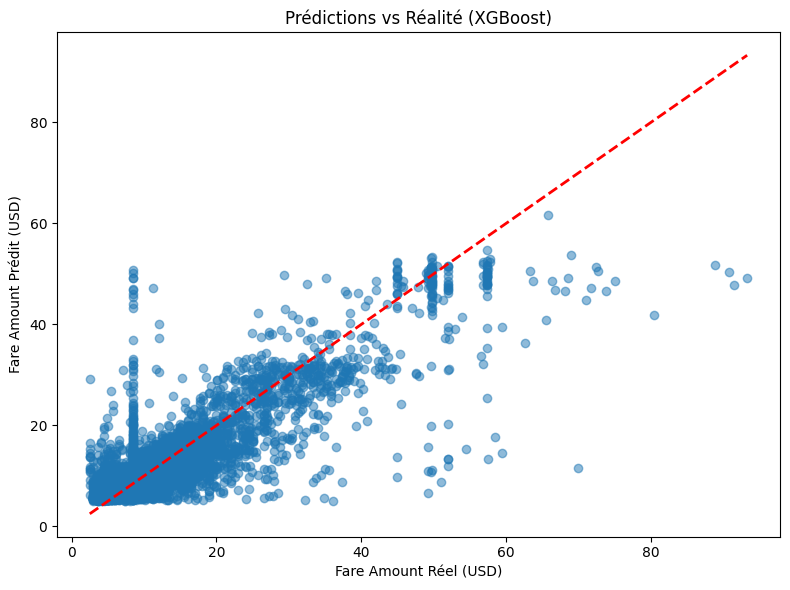

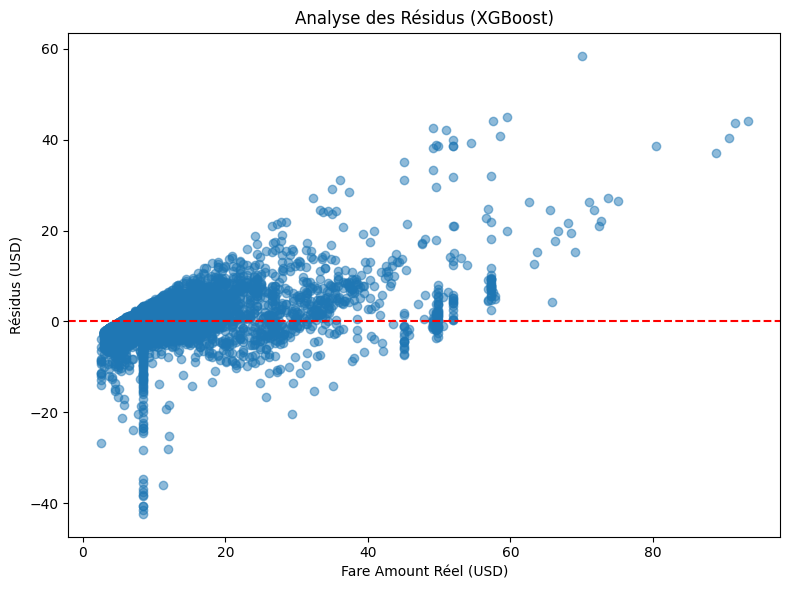


Importance des features :
                  feature  importance
              distance_km    0.885798
                 is_night    0.036048
             is_peak_hour    0.022553
                     hour    0.014940
distance_hour_interaction    0.013511
                    month    0.010930
              day_of_week    0.009392
          passenger_count    0.006828
               is_weekend    0.000000


In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 1. Calcul de la distance Haversine entre pickup et dropoff
def haversine(lon1, lat1, lon2, lat2):
    # Convertir en radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Différences
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    # Formule Haversine
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Rayon de la Terre en km
    return c * r

# Supposons que votre dataframe 'df' est déjà chargé depuis Excel avec les colonnes :
# key, fare_amount, pickup_datetime, pickup_longitude, pickup_latitude,
# dropoff_longitude, dropoff_latitude, passenger_count, distance_km

# Appliquer la fonction uniquement si les coordonnées sont valides
df['distance_km'] = df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'],
                                                  row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Feature engineering
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, errors='coerce')
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_night'] = df['hour'].apply(lambda x: 1 if x >= 22 or x < 6 else 0)
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if x in [7, 8, 9, 16, 17, 18] else 0)
df['distance_hour_interaction'] = df['distance_km'] * df['hour']

# Nettoyage des outliers
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 50)]

# Features sélectionnées
features = [
    "distance_km", "hour", "day_of_week", "passenger_count",
    "distance_hour_interaction", "is_weekend", "is_night", "is_peak_hour", "month"
]
X = df[features]
y = df["fare_amount"]

# Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optimisation des hyperparamètres avec GridSearchCV pour XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle
model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Exemple de valeurs réelles et prédites
results = pd.DataFrame({
    "fare_amount_réel": y_test,
    "fare_amount_prédit": y_pred,
    "distance_km": df.loc[y_test.index, "distance_km"]
})
print("\nExemple de valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Visualisation des prédictions vs réalité
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Fare Amount Réel (USD)")
plt.ylabel("Fare Amount Prédit (USD)")
plt.title("Prédictions vs Réalité (XGBoost)")
plt.tight_layout()
plt.show()

# Analyse des résidus
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fare Amount Réel (USD)")
plt.ylabel("Résidus (USD)")
plt.title("Analyse des Résidus (XGBoost)")
plt.tight_layout()
plt.show()

# Importance des features
importances = model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importances})
print("\nImportance des features :")
print(feature_importance.sort_values('importance', ascending=False).to_string(index=False))

R² Score: 0.68
Mean Absolute Error (MAE): 2.71
Root Mean Squared Error (RMSE): 5.28

Exemple de 10 valeurs réelles et prédites :
 fare_amount_réel  fare_amount_prédit  distance_km
             3.70                6.18         1.16
            49.15               45.47        19.42
             5.50                6.78         1.22
             5.30                6.23         1.06
            31.07               28.37         9.76
            12.50                9.02         2.31
             6.10                5.97         1.39
            14.50               14.93         4.94
             7.30               10.09         3.16
             5.00                6.06         1.05


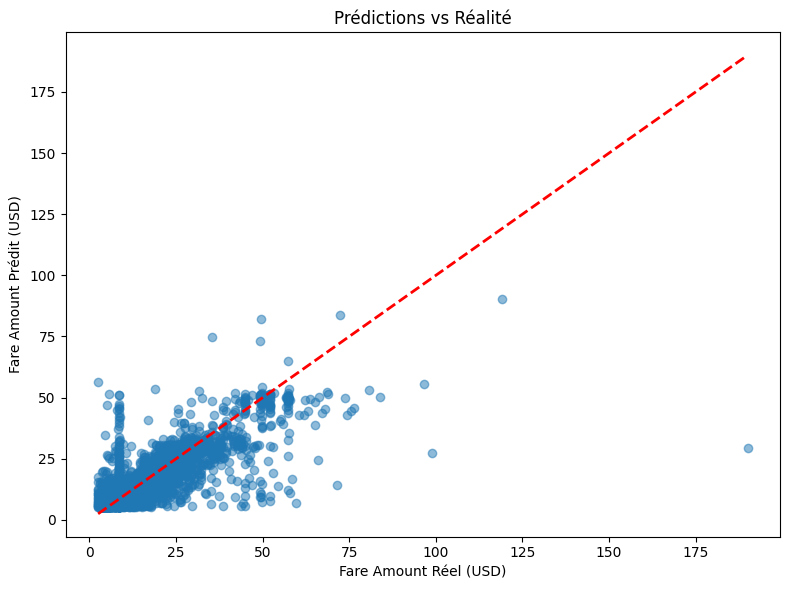

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt



# Entraîner le modèle avec les hyperparamètres fixes
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Exemple de valeurs
results = pd.DataFrame({"fare_amount_réel": y_test, "fare_amount_prédit": y_pred, "distance_km": X_test["distance_km"]})
print("\nExemple de 10 valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Fare Amount Réel (USD)")
plt.ylabel("Fare Amount Prédit (USD)")
plt.title("Prédictions vs Réalité")
plt.tight_layout()
plt.show()

Mean Absolute Error (MAE): 3.08
Root Mean Squared Error (RMSE): 6.70
R² Score: 0.48

Exemple de 10 valeurs réelles et prédites :
 fare_amount_réel  fare_amount_prédit  distance_km
             3.70                7.38         1.16
            49.15               39.32        19.42
             5.50                7.71         1.22
             5.30                7.08         1.06
            31.07               22.33         9.76
            12.50                9.27         2.31
             6.10                7.74         1.39
            14.50               13.92         4.94
             7.30               10.72         3.16
             5.00                7.12         1.05


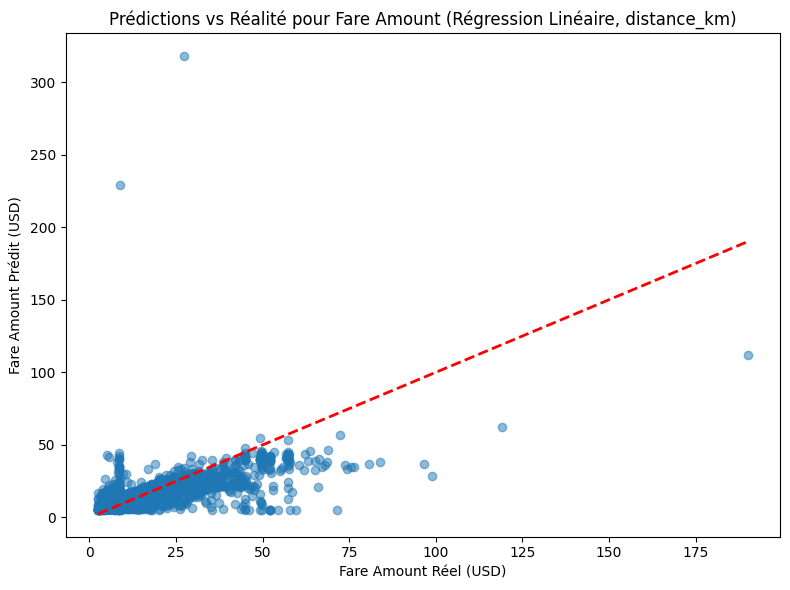

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Exemple de valeurs réelles et prédites
results = pd.DataFrame({
    "fare_amount_réel": y_test,
    "fare_amount_prédit": y_pred,
    "distance_km": X_test["distance_km"]
})
print("\nExemple de 10 valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Fare Amount Réel (USD)")
plt.ylabel("Fare Amount Prédit (USD)")
plt.title("Prédictions vs Réalité pour Fare Amount (Régression Linéaire, distance_km)")
plt.tight_layout()
plt.show()

Mean Absolute Error (MAE): 0.47 minutes
Root Mean Squared Error (RMSE): 0.60 minutes
R² Score: 0.99

Exemple de 10 valeurs réelles et prédites :
 waiting_time_real_min  waiting_time_pred_min                     booking_time               pickup_time  booking_hour  booking_minute  booking_dayofweek  pickup_hour  pickup_minute  pickup_dayofweek  traffic_level
                 37.39                  37.63 2010-08-30 07:14:46.576127+00:00 2010-08-30 07:52:10+00:00             7              14                  0            7             52                 0              4
                 15.49                  16.10 2009-01-10 16:04:30.356589+00:00 2009-01-10 16:20:00+00:00            16               4                  5           16             20                 5              3
                 10.70                  10.96 2015-06-16 19:03:39.720014+00:00 2015-06-16 19:14:22+00:00            19               3                  1           19             14                 1           

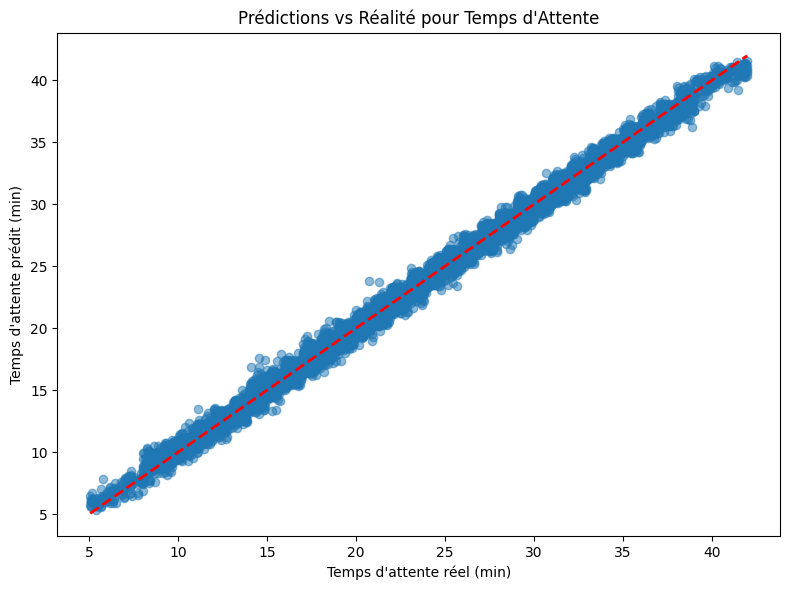


Dataset sauvegardé dans 'waiting_time_data_components.csv' pour vérification.


In [ ]:
#Data preparation for DSO2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import radians, cos, sin, asin, sqrt
from datetime import timedelta
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Charger le dataset
df = pd.read_excel("datauber.xlsx")

# === Nettoyage et préparation (repris de ton code) ===
df = df.drop_duplicates()
df["passenger_count"] = df["passenger_count"].fillna(1)
df["fare_amount"] = df["fare_amount"].fillna(df["fare_amount"].median())
for col in ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]:
    df[col] = df[col].fillna(df[col].median())

df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
most_freq_date = df["pickup_datetime"].mode()[0]
df["pickup_datetime"] = df["pickup_datetime"].fillna(most_freq_date)

df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 200)]
df = df[(df["passenger_count"] > 0) & (df["passenger_count"] <= 6)]
df = df[(df["pickup_longitude"] > -80) & (df["pickup_longitude"] < -70)]
df = df[(df["pickup_latitude"] > 35) & (df["pickup_latitude"] < 45)]
df = df[(df["dropoff_longitude"] > -80) & (df["dropoff_longitude"] < -70)]
df = df[(df["dropoff_latitude"] > 35) & (df["dropoff_latitude"] < 45)]
df = df[~((df["pickup_longitude"] == df["dropoff_longitude"]) &
          (df["pickup_latitude"] == df["dropoff_latitude"]))]

# pickup_time = pickup_datetime
df["pickup_time"] = df["pickup_datetime"]

# Traffic_level basé sur l'heure de booking_time (calculé après génération)
def traffic_from_hour(hour, day_of_week):
    if 0 <= hour < 5: return 0
    elif 5 <= hour < 7: return 1
    elif 7 <= hour < 9 or 17 <= hour < 19: return 4
    elif 9 <= hour < 10 or 16 <= hour < 17: return 3
    elif 10 <= hour < 16: return 2
    else: return 1 if day_of_week < 5 else 3

# Génération synthétique de booking_time (réservation avant pickup)
df["temp_traffic_level"] = df.apply(lambda row: traffic_from_hour(row["pickup_time"].hour, row["pickup_time"].dayofweek), axis=1)
df["waiting_minutes"] = np.random.uniform(5, 30, len(df)) + df["temp_traffic_level"] * 3  # Délai ajusté par trafic
df["booking_time"] = df["pickup_time"] - df.apply(lambda row: timedelta(minutes=row["waiting_minutes"]), axis=1)

# Recalculer traffic_level basé sur booking_time
df["booking_hour"] = df["booking_time"].dt.hour
df["booking_dayofweek"] = df["booking_time"].dt.dayofweek
df["traffic_level"] = df.apply(lambda row: traffic_from_hour(row["booking_hour"], row["booking_dayofweek"]), axis=1)

# Cible : waiting_time_min
df["waiting_time_min"] = (df["pickup_time"] - df["booking_time"]).dt.total_seconds() / 60.0
df = df[(df["waiting_time_min"] > 0) & (df["waiting_time_min"] < 120)]

# Features : hour, minute, dayofweek pour booking_time et pickup_time, plus traffic_level
df["booking_minute"] = df["booking_time"].dt.minute
df["pickup_hour"] = df["pickup_time"].dt.hour
df["pickup_minute"] = df["pickup_time"].dt.minute
df["pickup_dayofweek"] = df["pickup_time"].dt.dayofweek

features = ["booking_hour", "booking_minute", "booking_dayofweek",
            "pickup_hour", "pickup_minute", "pickup_dayofweek",
            "traffic_level"]
X = df[features]
y = df["waiting_time_min"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
print(f"R² Score: {r2:.2f}")

# Exemple de 10 valeurs réelles et prédites
results = pd.DataFrame({
    "waiting_time_real_min": y_test,
    "waiting_time_pred_min": y_pred,
    "booking_time": df.loc[y_test.index, "booking_time"],
    "pickup_time": df.loc[y_test.index, "pickup_time"],
    **{f: X_test[f] for f in features}
})
print("\nExemple de 10 valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Importance des features
feature_importance = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)
print("\nImportance des features :")
print(feature_importance.to_string(index=False))

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Temps d'attente réel (min)")
plt.ylabel("Temps d'attente prédit (min)")
plt.title("Prédictions vs Réalité pour Temps d'Attente")
plt.tight_layout()
plt.show()

# Sauvegarde
df[["booking_time", "pickup_time", "waiting_time_min"] + features].to_csv("waiting_time_data_components.csv", index=False)
print("\nDataset sauvegardé dans 'waiting_time_data_components.csv' pour vérification.")

Mean Absolute Error (MAE): 6.28 minutes
Root Mean Squared Error (RMSE): 7.33 minutes
R² Score: 0.17

Exemple de 10 valeurs réelles et prédites :
 waiting_time_real_min  waiting_time_pred_min                     booking_time               pickup_time  booking_hour  booking_minute  booking_dayofweek  pickup_hour  pickup_minute  pickup_dayofweek  traffic_level
                 37.39                  29.20 2010-08-30 07:14:46.576127+00:00 2010-08-30 07:52:10+00:00             7              14                  0            7             52                 0              4
                 15.49                  26.44 2009-01-10 16:04:30.356589+00:00 2009-01-10 16:20:00+00:00            16               4                  5           16             20                 5              3
                 10.70                  20.97 2015-06-16 19:03:39.720014+00:00 2015-06-16 19:14:22+00:00            19               3                  1           19             14                 1           

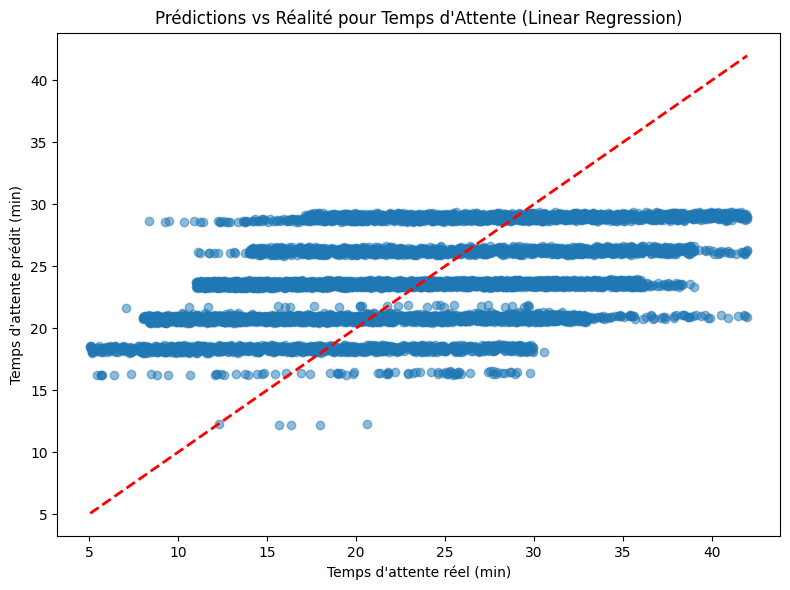

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# On suppose que X_train, X_test, y_train, y_test, features, et df sont déjà définis
# (après la préparation des données comme dans ton code)

# Modèle Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
print(f"R² Score: {r2:.2f}")

# Exemple de 10 valeurs réelles et prédites
results = pd.DataFrame({
    "waiting_time_real_min": y_test,
    "waiting_time_pred_min": y_pred,
    "booking_time": df.loc[y_test.index, "booking_time"],
    "pickup_time": df.loc[y_test.index, "pickup_time"],
    **{f: X_test[f] for f in features}
})
print("\nExemple de 10 valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Pas d'importance des features pour Linear Regression (utilise les coefficients si besoin)
print("\nCoefficients des features pour Linear Regression :")
coeffs = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_
}).sort_values("coefficient", ascending=False)
print(coeffs.to_string(index=False))

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Temps d'attente réel (min)")
plt.ylabel("Temps d'attente prédit (min)")
plt.title("Prédictions vs Réalité pour Temps d'Attente (Linear Regression)")
plt.tight_layout()
plt.show()

Variance expliquée par PCA : 0.68
Silhouette Score pour K-Means : 0.39
Silhouette Score pour DBSCAN : 0.63


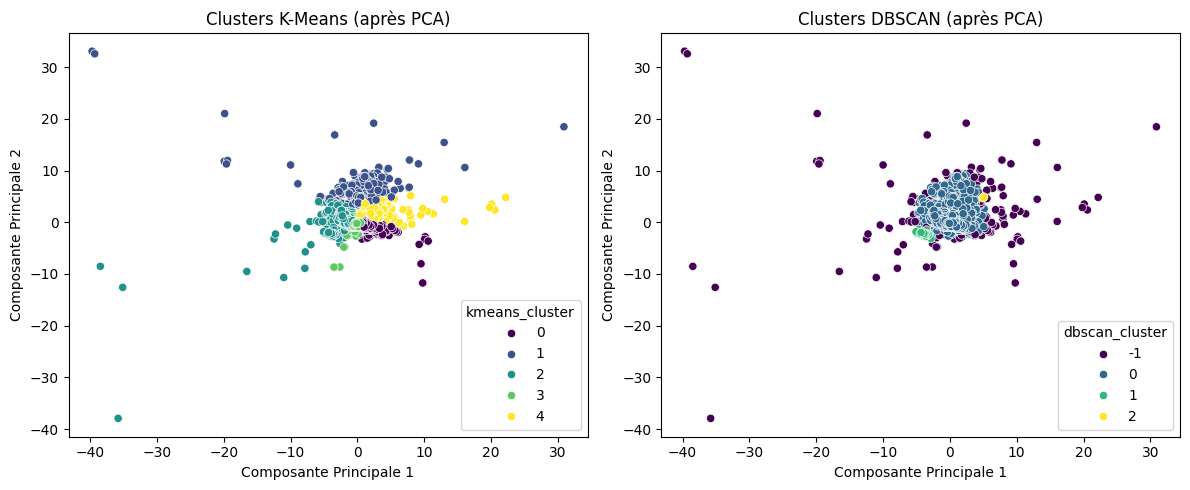


Dataset avec clusters sauvegardé dans 'clustered_data_dso3.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le dataset
df = pd.read_excel("datauber.xlsx")

# === Nettoyage et préparation des données ===
df = df.drop_duplicates()

df["passenger_count"] = df["passenger_count"].fillna(1)
df["fare_amount"] = df["fare_amount"].fillna(df["fare_amount"].median())
for col in ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]:
    df[col] = df[col].fillna(df[col].median())

df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
most_freq_date = df["pickup_datetime"].mode()[0]
df["pickup_datetime"] = df["pickup_datetime"].fillna(most_freq_date)

# Nettoyage valeurs aberrantes
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 200)]
df = df[(df["passenger_count"] > 0) & (df["passenger_count"] <= 6)]

# Coordonnées réalistes NYC
df = df[(df["pickup_longitude"] > -80) & (df["pickup_longitude"] < -70)]
df = df[(df["pickup_latitude"] > 35) & (df["pickup_latitude"] < 45)]
df = df[(df["dropoff_longitude"] > -80) & (df["dropoff_longitude"] < -70)]
df = df[(df["dropoff_latitude"] > 35) & (df["dropoff_latitude"] < 45)]

# pickup != dropoff
df = df[~((df["pickup_longitude"] == df["dropoff_longitude"]) &
          (df["pickup_latitude"] == df["dropoff_latitude"]))]

# Sélection des features pour clustering : coordonnées géographiques
geo_features = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
X_geo = df[geo_features]

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_geo)

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variance expliquée par PCA : {pca.explained_variance_ratio_.sum():.2f}")

# === Clustering avec K-Means ===
kmeans = KMeans(n_clusters=5, random_state=42)  # Choisir 5 clusters pour exemple ; ajuste avec elbow method si besoin
df["kmeans_cluster"] = kmeans.fit_predict(X_pca)

# Évaluation K-Means
silhouette_kmeans = silhouette_score(X_pca, df["kmeans_cluster"])
print(f"Silhouette Score pour K-Means : {silhouette_kmeans:.2f}")

# === Clustering avec DBSCAN ===
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajuste eps et min_samples selon tes données
df["dbscan_cluster"] = dbscan.fit_predict(X_pca)

# Évaluation DBSCAN (seulement si au moins 2 clusters, ignore les bruits pour le score)
if len(np.unique(df["dbscan_cluster"])) > 1:
    silhouette_dbscan = silhouette_score(X_pca[df["dbscan_cluster"] != -1], df["dbscan_cluster"][df["dbscan_cluster"] != -1])
    print(f"Silhouette Score pour DBSCAN : {silhouette_dbscan:.2f}")
else:
    print("DBSCAN n'a pas produit assez de clusters pour évaluation.")

# Visualisation des clusters K-Means
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["kmeans_cluster"], palette="viridis")
plt.title("Clusters K-Means (après PCA)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")

# Visualisation des clusters DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["dbscan_cluster"], palette="viridis")
plt.title("Clusters DBSCAN (après PCA)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")

plt.tight_layout()
plt.show()

# Sauvegarder le dataset avec clusters
df.to_csv("clustered_data_dso3.csv", index=False)
print("\nDataset avec clusters sauvegardé dans 'clustered_data_dso3.csv'.")

In [ ]:
#5. EVALUATION & TEST
#Assess the performance of the models and determine if they meet the business objectives.

In [ ]:
#6. DEPLOYMENT
#Implement the chosen model into a real-world application or deliver the results to stakeholders.